# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [96]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [4]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu'):
    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        if (epochs) % 10 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [5]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu'):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()
            }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [6]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

In [41]:
def data_func(input_array, labels, batch_size = 32, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [29]:
# Define the pickle file name and relative path
pickle_name = "Sim_Data_Noisy_Interp.pkl"
folder_name = "Sim_Data_0"  # Change accordingly

relative_path = os.path.join("..", "Simulation", folder_name, pickle_name)

# Resolve the absolute path
file_path = os.path.abspath(relative_path)

try:
    # Check if the file exists before attempting to read
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Load the pickle file
    df = pd.read_pickle(file_path)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df.head()


,tag_pos,Antenna,robot_pos,Phases
0,"[1.3374070790110344, 0.1, 0.1]",[0],"[0.6625929209889657, 0.6661549086159794, 0.669...","[0.0, -0.10487150506512838, -0.221901548402660..."
1,"[1.9494820917610742, 0.1, 0.1]",[0],"[0.05051790823892587, 0.054072937717603915, 0....","[0.0, -0.10101337624334959, -0.321809004322664..."
2,"[0.4116242295452528, 0.1, 0.1]",[0],"[1.5883757704547472, 1.5920683760992664, 1.595...","[0.0, -0.13453695823921752, -0.255845581716036..."
3,"[1.2026705067177903, 0.1, 0.1]",[0],"[0.7973294932822097, 0.80090229956099, 0.80447...","[0.0, -0.14502076970326194, -0.377630922159475..."
4,"[1.4467800565600593, 0.1, 0.1]",[0],"[0.5532199434399407, 0.5567733429395528, 0.560...","[0.0, -0.12889416459989012, -0.239887498367972..."


Δημιουργούμε τα training και testing sets.

In [38]:
rfid_label = np.array(df['tag_pos'].tolist())[:, :2] 
rfid_label.shape

(10000, 2)

In [53]:
# Convert columns to NumPy arrays
robot_pos_array = np.stack(df["robot_pos"].to_numpy())  # Shape: (10000, 400)
phases_array = np.stack(df["Phases"].to_numpy())  # Shape: (10000, 400)

# Concatenate along the last axis
info_tensor = np.stack((robot_pos_array, phases_array), axis=-1)  # Shape: (10000, 400, 2)
info_tensor.shape

(10000, 400, 2)

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως κινήθηκε κατά τον άξονα **Χ** και την μέτρηση της **φάσης** του.

In [44]:
train_loader, test_loader = data_func(info_tensor, rfid_label)

In [48]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition 

250

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [68]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(800, 2)

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [49]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 2.3250767704844475 | Loss test: 1.368966193426223 | lr = 0.01
Epoch 10 | Loss train: 1.1208249682188034 | Loss test: 1.2774216930071514 | lr = 0.01
Epoch 20 | Loss train: 0.2930543532371521 | Loss test: 0.3138357022451976 | lr = 0.001
Epoch 30 | Loss train: 0.2526529198586941 | Loss test: 0.2516119333486708 | lr = 0.0001
Epoch 40 | Loss train: 0.24922462344169616 | Loss test: 0.2474644955188509 | lr = 0.0001
Epoch 50 | Loss train: 0.24485082292556762 | Loss test: 0.2466698825832397 | lr = 1e-05
Epoch 60 | Loss train: 0.24505824396014214 | Loss test: 0.24671197883666507 | lr = 1e-05
Epoch 70 | Loss train: 0.24514249408245087 | Loss test: 0.24649713886162591 | lr = 1e-05
Epoch 80 | Loss train: 0.2443954989016056 | Loss test: 0.2465618025688898 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.24435716995596884 | Loss test: 0.24654164626484826 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.24434505295753478 | Loss test: 0.24653493955967917 | lr = 1.0000

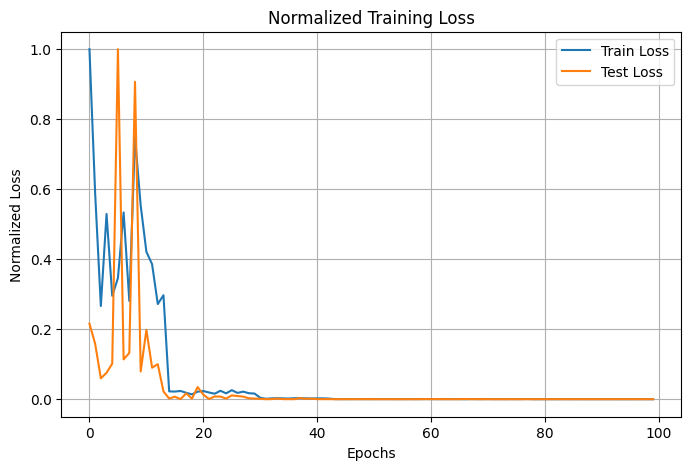

In [60]:
# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 69.74376517665387 | Loss test: 1.1069220380177573 | lr = 0.01
Epoch 10 | Loss train: 19.32845504236221 | Loss test: 41.88346172514416 | lr = 0.01
Epoch 20 | Loss train: 0.424964996099472 | Loss test: 0.40487701008244165 | lr = 0.001
Epoch 30 | Loss train: 0.4213848668336868 | Loss test: 0.4871986115735675 | lr = 0.001
Epoch 40 | Loss train: 0.4257952623963356 | Loss test: 0.38722488733511123 | lr = 0.001
Epoch 50 | Loss train: 0.4275430011153221 | Loss test: 0.29105869006542934 | lr = 0.0001
Epoch 60 | Loss train: 0.25140517342090607 | Loss test: 0.2483732554884184 | lr = 0.0001
Epoch 70 | Loss train: 0.24646360182762145 | Loss test: 0.24753696554236942 | lr = 1e-05
Epoch 80 | Loss train: 0.24662488344311714 | Loss test: 0.2477470383284584 | lr = 1e-05
Epoch 90 | Loss train: 0.24607605150341988 | Loss test: 0.2476150043426998 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.24595560231804847 | Loss test: 0.24755641203078013 | lr = 1.0000000000000002e-06


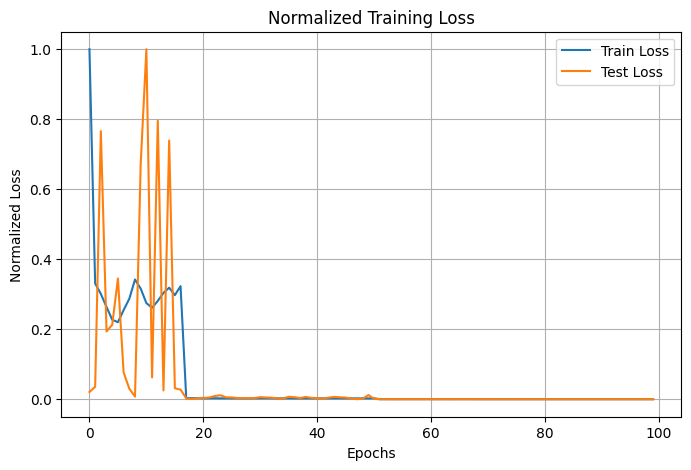

In [58]:
# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 0.7230973426699638 | Loss test: 0.3768488953983973 | lr = 0.01
Epoch 10 | Loss train: 0.3336524920463562 | Loss test: 0.36884454933423844 | lr = 0.01
Epoch 20 | Loss train: 0.2575630963742733 | Loss test: 0.26772179087949177 | lr = 0.001
Epoch 30 | Loss train: 0.24855450490117073 | Loss test: 0.2474221367211569 | lr = 0.0001
Epoch 40 | Loss train: 0.2467126331627369 | Loss test: 0.24763859217129056 | lr = 1e-05
Epoch 50 | Loss train: 0.24546317133307458 | Loss test: 0.2468755661495148 | lr = 1e-05
Epoch 60 | Loss train: 0.24554098904132843 | Loss test: 0.2470047138040028 | lr = 1e-05
Epoch 70 | Loss train: 0.24555609685182572 | Loss test: 0.24700850697736892 | lr = 1e-05
Epoch 80 | Loss train: 0.24524947908520697 | Loss test: 0.24685994452900356 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.24524350363016129 | Loss test: 0.24686190225775279 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.24523854514956475 | Loss test: 0.24685825549420856 | lr = 1.

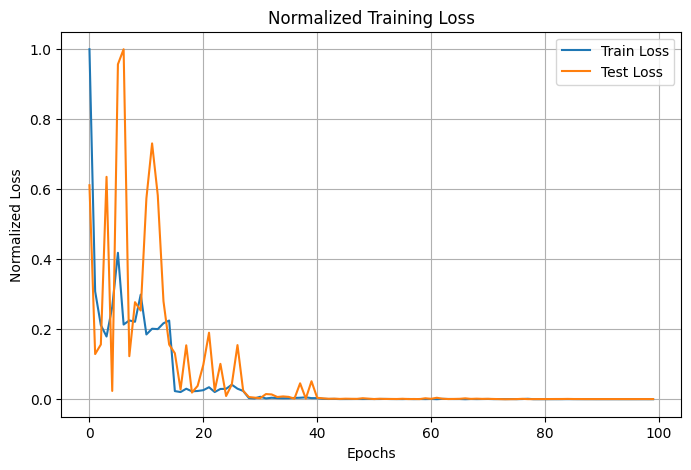

In [62]:
# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [106]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.6694437893778085 | Loss test: 0.07930363998526618 | lr = 0.01
Epoch 10 | Loss train: 0.0313122744821012 | Loss test: 0.03891345344129063 | lr = 0.01
Epoch 20 | Loss train: 0.03469504941254854 | Loss test: 0.026886736412370014 | lr = 0.01
Epoch 30 | Loss train: 0.006144787167198956 | Loss test: 0.005455975834694173 | lr = 0.001
Epoch 40 | Loss train: 0.0056258329981938 | Loss test: 0.00595718526488377 | lr = 0.001
Epoch 50 | Loss train: 0.0056991323148831725 | Loss test: 0.005687962733356962 | lr = 0.001
Epoch 60 | Loss train: 0.005275468346662819 | Loss test: 0.0048794972392479105 | lr = 0.001
Epoch 70 | Loss train: 0.012523438094649463 | Loss test: 0.005009845775064258 | lr = 0.001
Epoch 80 | Loss train: 0.005164180832915008 | Loss test: 0.004800488717765326 | lr = 0.001
Epoch 90 | Loss train: 0.004259793861303479 | Loss test: 0.004163523832897818 | lr = 0.0001
Epoch 100 | Loss train: 0.00418874291330576 | Loss test: 0.004063742922707682 | lr = 0.0001


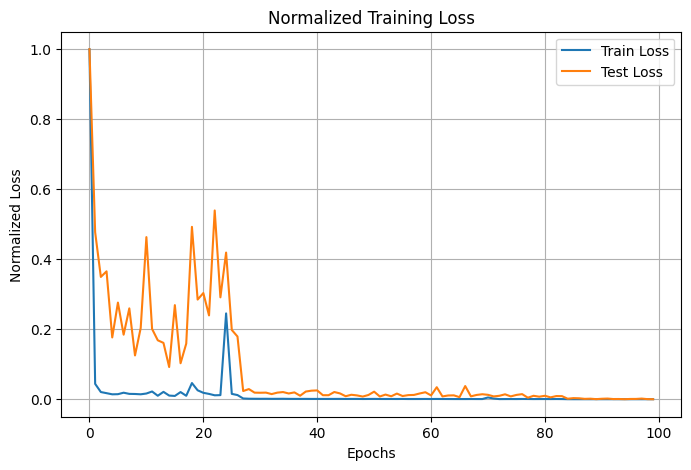

In [64]:
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, loss_fn, device)

In [65]:
relu_model

{'model_name': 'ReLUModel', 'model_loss': 0.0040637431666255}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική.

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 3.323811037302017 | Loss test: 0.10718882202156006 | lr = 0.01
Epoch 10 | Loss train: 0.07690636231936514 | Loss test: 0.02714036541089179 | lr = 0.01
Epoch 20 | Loss train: 0.0194489340223372 | Loss test: 0.012449935566456545 | lr = 0.01
Epoch 30 | Loss train: 0.023073145298287273 | Loss test: 0.0422870803269602 | lr = 0.01
Epoch 40 | Loss train: 0.005399943896569312 | Loss test: 0.004768396731436489 | lr = 0.001
Epoch 50 | Loss train: 0.00504576675221324 | Loss test: 0.005363943469193246 | lr = 0.001
Epoch 60 | Loss train: 0.0049971702378243206 | Loss test: 0.004606942982516355 | lr = 0.001
Epoch 70 | Loss train: 0.004912663966417313 | Loss test: 0.004432546248334268 | lr = 0.001
Epoch 80 | Loss train: 0.004807117506861687 | Loss test: 0.005520740139579016 | lr = 0.001
Epoch 90 | Loss train: 0.004685650742612779 | Loss test: 0.004441370296898106 | lr = 0.001
Epoch 100 | Loss train: 0.004500476525630802 | Loss test: 0.004385724926130876 | lr = 0.001


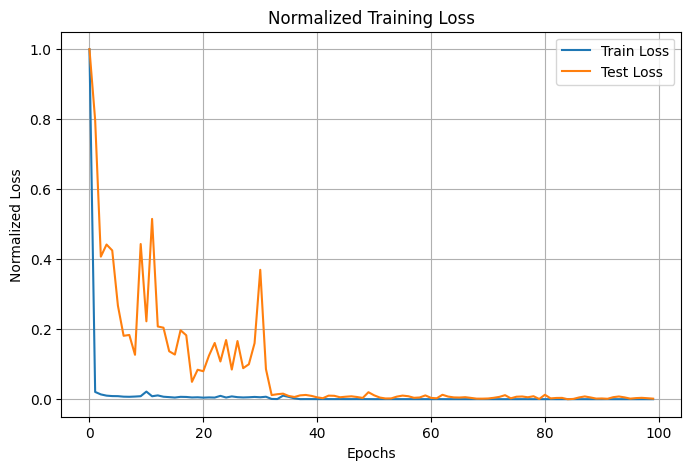

In [69]:
# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, loss_fn, device)

In [70]:
relu_model_256, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.004385726060718298},
 {'model_name': 'ReLUModel', 'model_loss': 0.0040637431666255})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64.

Epoch 0 | Loss train: 0.47603345385193824 | Loss test: 0.03930269672520577 | lr = 0.01
Epoch 10 | Loss train: 0.01774717501923442 | Loss test: 0.01485203281931934 | lr = 0.01
Epoch 20 | Loss train: 0.014655266957357525 | Loss test: 0.014774887985180295 | lr = 0.01
Epoch 30 | Loss train: 0.013602569311857224 | Loss test: 0.01481289721079289 | lr = 0.01
Epoch 40 | Loss train: 0.00569861469604075 | Loss test: 0.0065945059297576785 | lr = 0.001
Epoch 50 | Loss train: 0.00511817682441324 | Loss test: 0.005423092057869312 | lr = 0.001
Epoch 60 | Loss train: 0.00808193324925378 | Loss test: 0.0049963667360504 | lr = 0.001
Epoch 70 | Loss train: 0.004718876626808196 | Loss test: 0.004449169114527721 | lr = 0.001
Epoch 80 | Loss train: 0.0046251412485726175 | Loss test: 0.004477100380297218 | lr = 0.001
Epoch 90 | Loss train: 0.004529544804710895 | Loss test: 0.0042254688026058295 | lr = 0.001
Epoch 100 | Loss train: 0.003943265353795141 | Loss test: 0.003812098173454167 | lr = 0.0001


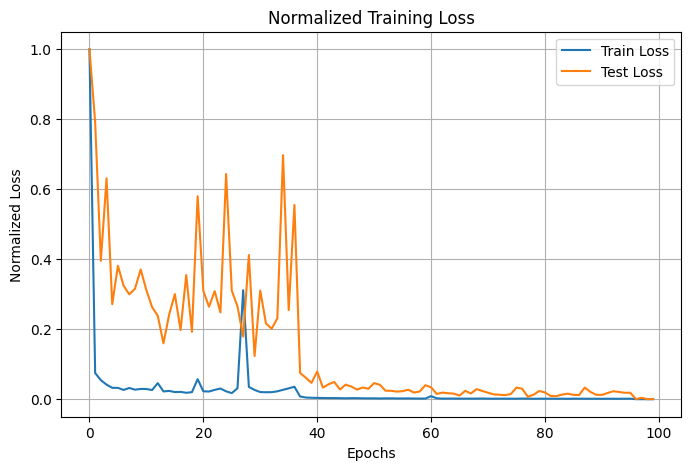

In [71]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, loss_fn, device)

In [72]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.004385726060718298},
 {'model_name': 'ReLUModel', 'model_loss': 0.003812098875641823},
 {'model_name': 'ReLUModel', 'model_loss': 0.0040637431666255})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```, αλλά για την ώρα κρατάμε τα 128

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [73]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.5471287586539983 | Loss test: 0.07485513832597505 | lr = 0.01
Epoch 10 | Loss train: 0.029643960209563374 | Loss test: 0.01720831377638711 | lr = 0.01
Epoch 20 | Loss train: 0.04156330190040171 | Loss test: 0.012590885125396271 | lr = 0.01
Epoch 30 | Loss train: 0.055789249716326594 | Loss test: 0.014934081798567185 | lr = 0.01
Epoch 40 | Loss train: 0.05365776718966663 | Loss test: 0.07126911108692487 | lr = 0.01
Epoch 50 | Loss train: 0.017928118534386157 | Loss test: 0.010780169835521115 | lr = 0.01
Epoch 60 | Loss train: 0.005638942040503025 | Loss test: 0.0047922826349912654 | lr = 0.001
Epoch 70 | Loss train: 0.005091937861870974 | Loss test: 0.004728243098638597 | lr = 0.001
Epoch 80 | Loss train: 0.004669276625849306 | Loss test: 0.004481122411403154 | lr = 0.001
Epoch 90 | Loss train: 0.004080517192836851 | Loss test: 0.003835590234735892 | lr = 0.0001
Epoch 100 | Loss train: 0.0036630676025524735 | Loss test: 0.0036770113788190343 | lr = 0.0001


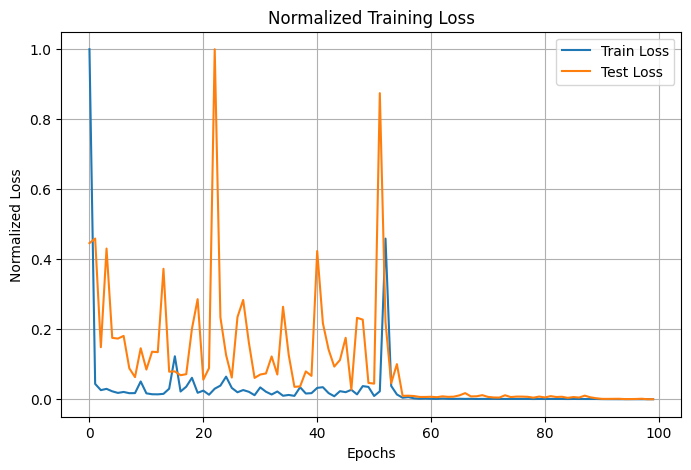

In [74]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, loss_fn, device)

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [75]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.40503761783242226 | Loss test: 0.17725692393760833 | lr = 0.01
Epoch 10 | Loss train: 0.16328592979907988 | Loss test: 0.33059636278757976 | lr = 0.01
Epoch 20 | Loss train: 0.11659628754854202 | Loss test: 0.2518025799876168 | lr = 0.01
Epoch 30 | Loss train: 0.12995313262939454 | Loss test: 0.12373614121997167 | lr = 0.01
Epoch 40 | Loss train: 0.05409521716088057 | Loss test: 0.054005223075075756 | lr = 0.001
Epoch 50 | Loss train: 0.045323161587119104 | Loss test: 0.046109017132530135 | lr = 0.001
Epoch 60 | Loss train: 0.03970972715318203 | Loss test: 0.041614656706178 | lr = 0.001
Epoch 70 | Loss train: 0.03429127015173435 | Loss test: 0.04069895995041681 | lr = 0.001
Epoch 80 | Loss train: 0.02922658707201481 | Loss test: 0.03295379708565417 | lr = 0.001
Epoch 90 | Loss train: 0.02725014577433467 | Loss test: 0.029580358844546097 | lr = 0.001
Epoch 100 | Loss train: 0.024591336503624914 | Loss test: 0.0294110006135371 | lr = 0.001


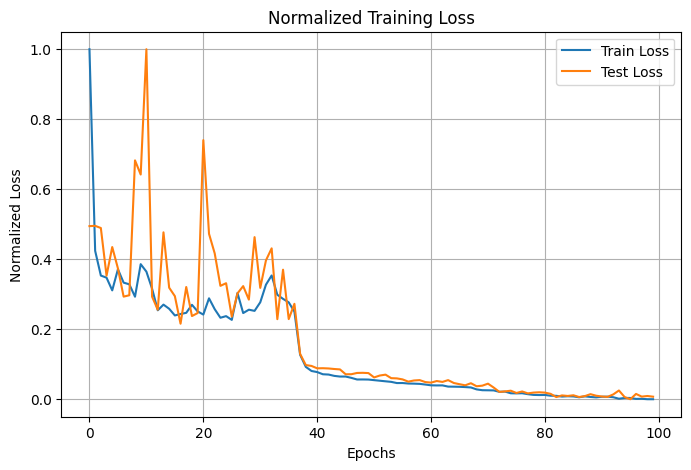

In [76]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, loss_fn, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [77]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.20547384825348855 | Loss test: 0.09451478104742747 | lr = 0.01
Epoch 10 | Loss train: 0.047311623483896253 | Loss test: 0.04335495054958358 | lr = 0.01
Epoch 20 | Loss train: 0.03702130104601383 | Loss test: 0.02636993760686545 | lr = 0.01
Epoch 30 | Loss train: 0.03354813801497221 | Loss test: 0.03131816388359145 | lr = 0.01
Epoch 40 | Loss train: 0.013255372449755668 | Loss test: 0.01281454080774907 | lr = 0.001
Epoch 50 | Loss train: 0.010549446837976574 | Loss test: 0.010279092021168225 | lr = 0.001
Epoch 60 | Loss train: 0.008823406886309386 | Loss test: 0.00940208054990286 | lr = 0.001
Epoch 70 | Loss train: 0.007972907718271017 | Loss test: 0.008908485949394248 | lr = 0.001
Epoch 80 | Loss train: 0.0072024302696809175 | Loss test: 0.007755713167762946 | lr = 0.001
Epoch 90 | Loss train: 0.006595239442773163 | Loss test: 0.007762946388018983 | lr = 0.001
Epoch 100 | Loss train: 0.0063862893572077155 | Loss test: 0.006924247642653802 | lr = 0.001


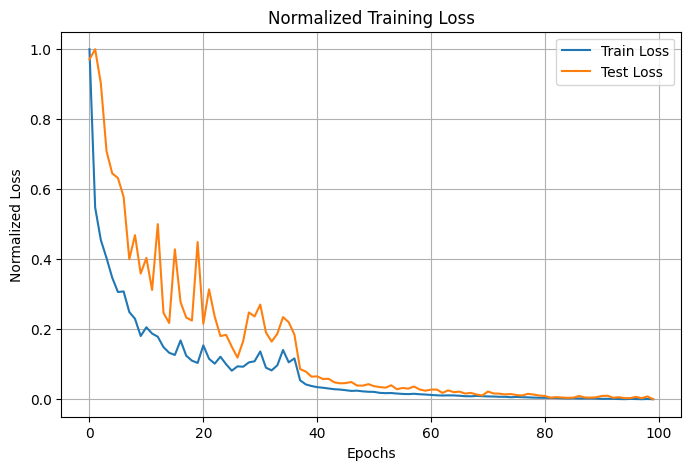

In [78]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, loss_fn, device)

### Αρχιτεκτονική 3

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [79]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.5448944762572645 | Loss test: 0.04561828656329049 | lr = 0.01
Epoch 10 | Loss train: 0.04317164299730211 | Loss test: 0.018736731645370288 | lr = 0.01
Epoch 20 | Loss train: 0.005275101500563323 | Loss test: 0.004673627238454563 | lr = 0.001
Epoch 30 | Loss train: 0.006679939651396126 | Loss test: 0.004425053906050466 | lr = 0.001
Epoch 40 | Loss train: 0.0039223792692646385 | Loss test: 0.003692521342253756 | lr = 0.0001
Epoch 50 | Loss train: 0.0035903036994859574 | Loss test: 0.0035745418419884075 | lr = 0.0001
Epoch 60 | Loss train: 0.0034996561142615974 | Loss test: 0.0036133971057891374 | lr = 0.0001
Epoch 70 | Loss train: 0.003498993874527514 | Loss test: 0.0036175788309986867 | lr = 0.0001
Epoch 80 | Loss train: 0.003362383375875652 | Loss test: 0.0036269675456135284 | lr = 0.0001
Epoch 90 | Loss train: 0.0034499879186041652 | Loss test: 0.0035465198498781003 | lr = 0.0001
Epoch 100 | Loss train: 0.003332753880415112 | Loss test: 0.0034807057190124713 | 

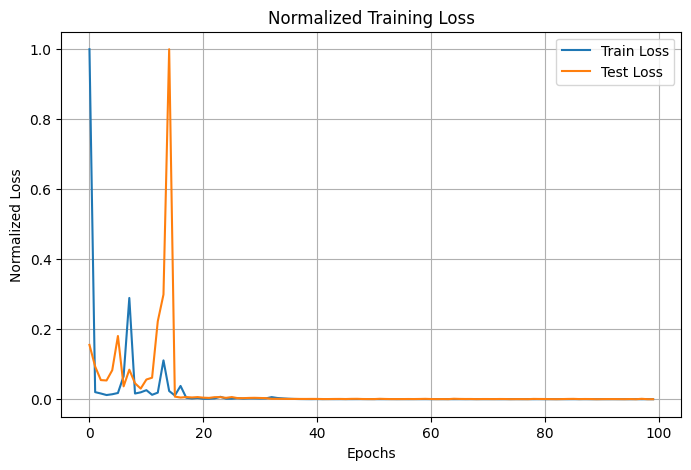

In [80]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, loss_fn, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [81]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.1246367864310742 | Loss test: 0.07886758174688097 | lr = 0.01
Epoch 10 | Loss train: 0.12746499732136726 | Loss test: 0.08228446407214043 | lr = 0.01
Epoch 20 | Loss train: 0.02340772803872824 | Loss test: 0.012846294576154342 | lr = 0.001
Epoch 30 | Loss train: 0.019157201059162618 | Loss test: 0.012954046114510486 | lr = 0.001
Epoch 40 | Loss train: 0.0157384145706892 | Loss test: 0.010209071834290784 | lr = 0.001
Epoch 50 | Loss train: 0.01510480497777462 | Loss test: 0.015222166590983905 | lr = 0.001
Epoch 60 | Loss train: 0.013895415825769305 | Loss test: 0.021749867658529962 | lr = 0.001
Epoch 70 | Loss train: 0.015082957945764065 | Loss test: 0.01451971469121793 | lr = 0.001
Epoch 80 | Loss train: 0.013474401023238897 | Loss test: 0.021826373487119636 | lr = 0.001
Epoch 90 | Loss train: 0.01391888497211039 | Loss test: 0.02147491660619539 | lr = 0.001
Epoch 100 | Loss train: 0.012343544408679009 | Loss test: 0.01900940997496484 | lr = 0.001
Epoch 110 | Lo

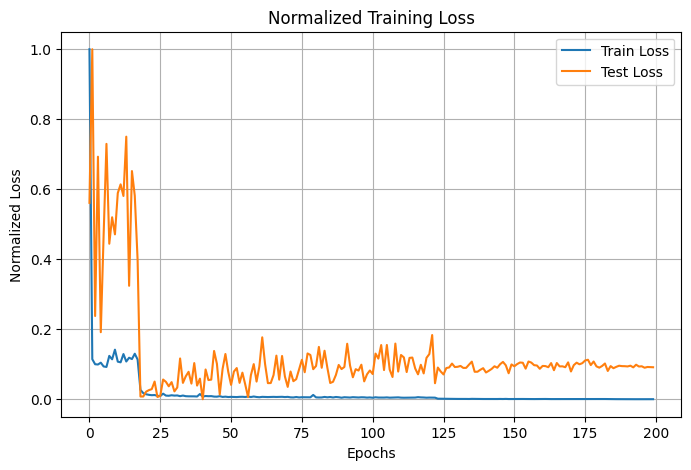

In [82]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

dropout_model = eval_model(model_11, test_loader, loss_fn, device)

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [94]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [101]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

xgb_loss = mean_squared_error(y_test, y_pred)

xgb_res = {'model_name': 'xgb_model', 'model_loss' : xgb_loss}

### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [144]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [135]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [145]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'model_loss' : test_loss.cpu().item()}

Epoch: 0 | Train Loss: 2.27833 | Test Loss: 26.40240
Epoch: 100 | Train Loss: 0.23033 | Test Loss: 0.22603
Epoch: 200 | Train Loss: 0.12230 | Test Loss: 0.12021
Epoch: 300 | Train Loss: 0.05981 | Test Loss: 0.06031
Epoch: 400 | Train Loss: 0.02815 | Test Loss: 0.02838
Epoch: 500 | Train Loss: 0.01381 | Test Loss: 0.01415
Epoch: 600 | Train Loss: 0.01195 | Test Loss: 0.01235
Epoch: 700 | Train Loss: 0.01156 | Test Loss: 0.01201
Epoch: 800 | Train Loss: 0.01135 | Test Loss: 0.01184
Epoch: 900 | Train Loss: 0.01117 | Test Loss: 0.01169
Epoch: 1000 | Train Loss: 0.01101 | Test Loss: 0.01154


## Results

In [146]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'model_loss', ascending= True, inplace= True)
compare_results

,model_name,model_loss
1,LeakyReLUModel4,0.003481
0,LeakyReLUModel,0.003677
2,ReLUModel,0.004064
6,xgb_model,0.006259
4,sigmoidModel,0.006924
7,LeakyReLU4_noBatches,0.011539
3,LeakyReLUModelDropout,0.021389
5,tanhModel,0.029411


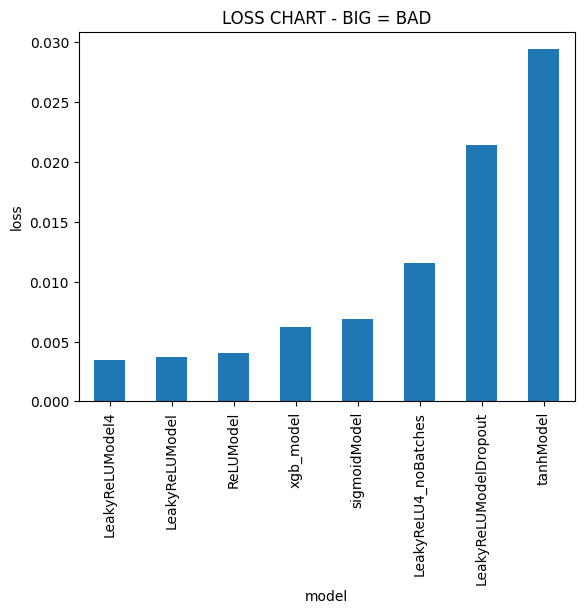

In [147]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("model")
plt.ylabel("loss")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***